In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional, Dict
import pickle

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from geographiclib.geodesic import Geodesic

from lib.state import PersonState
from lib.results import SimulationResult, SimulationResultStorage
%matplotlib inline

In [3]:
fraction_of_populace_returning_per_day = 0.001 
fraction_returning_travelers_infected = .01

max_distance_from_airport_km = 10

incubation_period_days = 5
days_sick = 14

avg_num_others_infected = 2.5
avg_num_others_infected_with_social_distancing = 1.5

prob_survive = 0.975

airport_location_lon = 4.764167
airport_location_lat = 52.308056

In [4]:
dfp = (
    gpd
    .read_file("./data/transformed/population.shp")
    .assign(centroid=lambda df: df["geometry"].map(lambda x: x.centroid))
    .drop("geometry", axis=1)
    .assign(
        airport_distance_km=
        lambda df: df["centroid"].map(
            lambda c: Geodesic.WGS84.Inverse(
                airport_location_lat, airport_location_lon, 
                c.y, c.x)["s12"] / 1000
        )
    )
)
len_dfp_all = len(dfp)
total_population = dfp["pop"].sum()

dfp = dfp[dfp["airport_distance_km"] < max_distance_from_airport_km]
dfp.index.name = "hood_id"
selected_population = dfp["pop"].sum()
print(f"{len_dfp_all} neighbourhoods in total "
      f"({total_population=}),\n"
      f"{len(dfp)} left after restricting on proximity "
      f"to airport ({selected_population=}).")
pd.concat((dfp.head(), dfp.tail()))

2794 neighbourhoods in total (total_population=16891285),
29 left after restricting on proximity to airport (selected_population=574280).


,hood,muni,pop,centroid,airport_distance_km
hood_id,,,,,
85,Wijk 00 Aalsmeer,Aalsmeer,12030,POINT (4.73681 52.25318),6.384820
86,Wijk 01 Kudelstraat en Kalslagen,Aalsmeer,9200,POINT (4.73985 52.23702),8.076712
87,Wijk 02 Oosteinde,Aalsmeer,9840,POINT (4.79539 52.28221),3.579371
188,Wijk 00 Amstelveen,Amstelveen,87160,POINT (4.85149 52.28927),6.313323
190,Stadsdeel Nieuw-West,Amsterdam,146575,POINT (4.80428 52.36224),6.620816
2401,Wijk 65 Meerwijk,Uithoorn,5885,POINT (4.81536 52.23359),8.992907
2402,Wijk 75 Bedrijventerrein,Uithoorn,255,POINT (4.84023 52.24019),9.164596
2403,Wijk 85 Meerwijk,Uithoorn,3420,POINT (4.78665 52.23680),8.076470
2404,Wijk 90 Glastuinbouwgebied,Uithoorn,315,POINT (4.75711 52.22944),8.761332


In [5]:
dfp.groupby("muni")["pop"].sum().sort_values(ascending=False).head(10)

muni
Amsterdam         287965
Haarlemmermeer    105990
Amstelveen         87160
Haarlem            32385
Aalsmeer           31070
Uithoorn           28715
De Ronde Venen       995
Name: pop, dtype: int64

In [6]:
def build_population_df_func(dfp: pd.DataFrame) -> pd.DataFrame:
    """Builds a DataFrame for the population where everyone is  
    still 'untouched' by the virus.
    """
    pop_hood_ids = []
    for hood_id, row in dfp.iterrows():
        pop_hood_ids.extend([hood_id] * row["pop"])
    assert len(pop_hood_ids) == selected_population
    
    def create_df():
        return pd.DataFrame({
            "person_id": range(selected_population),
            "infection_day": pd.NA,
            "state": PersonState.untouched,
            "hood_id": pop_hood_ids
        }).set_index("person_id") 
    return create_df

In [7]:
build_population_df = build_population_df_func(dfp)

In [8]:
pop = build_population_df()
pd.concat((pop.head(2), pop.tail(2)))

,infection_day,state,hood_id
person_id,,,
0,<NA>,PersonState.untouched,85
1,<NA>,PersonState.untouched,85
574278,<NA>,PersonState.untouched,2405
574279,<NA>,PersonState.untouched,2405


In [9]:
def simulate_spread(day: int, 
                    pop: pd.DataFrame,
                    prob_infect_daily: float, 
                    prob_infect_daily_with_social_distancing: float,
                    social_distancing_day: Optional[int] = None
                   ) -> pd.DataFrame:
    """Simulate the spreading of the virus within the population."""
    if isinstance(social_distancing_day, int) \
            and day >= social_distancing_day:
        # Social Distancing is in place!
        effective_prob_inf_daily = prob_infect_daily_with_social_distancing
    else:
        effective_prob_inf_daily = prob_infect_daily
    
    pop_contagious = (
        pop[(pop["state"] == PersonState.infected) &
            (pop["infection_day"] + incubation_period_days <= day)]
        .assign(infect_other=lambda df: 
                np.random.random(size=len(df)) < effective_prob_inf_daily)
        .query("infect_other == True")
    )
    pop_contagious_per_hood = pop_contagious.groupby("hood_id").sum()
    
    for hood_id, num_to_infect in pop_contagious_per_hood.itertuples():
        # Let's see who they spread the virus to. Only "untouched" will
        # actually be infected, the others already are or are immune.
        pop_to_spread_to = pop[
            (pop["hood_id"] == hood_id) &
            (pop["state"].isin({PersonState.untouched, 
                                PersonState.infected, 
                                PersonState.recovered}))
        ]
        # It might not be possible if the hood is completely saturated:
        n_to_spread_to = len(pop_to_spread_to)
        if n_to_spread_to == 0:
            continue
        
        # Or, spread to less people if the hood is partially saturated:
        num_to_infect = min(int(num_to_infect), n_to_spread_to)
        # Here, we allow spread of the virus to infected & recovered,
        # but we only let it have an effect on untouched:
        unlucky_persons = pop_to_spread_to.sample(num_to_infect, replace=False)
        unlucky_persons = unlucky_persons[
            unlucky_persons["state"] == PersonState.untouched
        ]
        unlucky_persons_idx = unlucky_persons.index
        
        if len(unlucky_persons_idx) > 0:
            pop.loc[unlucky_persons_idx, "state"] = PersonState.infected
            pop.loc[unlucky_persons_idx, "infection_day"] = day

    return pop

def simulate_cure_or_death(day: int, pop: pd.DataFrame) -> pd.DataFrame:
    """After `days_sick` days have elapsed, a person's state transitions to
    either deceased or recovered.
    """
    pop_to_decide = pop[(pop["state"] == PersonState.infected) &
                        (pop["infection_day"] < 
                         day - (days_sick + incubation_period_days))]
    n = len(pop_to_decide)
    pop_deceased_idx = pop_to_decide \
        .sample(int(n * (1 - prob_survive)), replace=False).index
    pop_recover_idx = set(pop_to_decide.index) - set(pop_deceased_idx)

    pop.loc[pop_recover_idx, "state"] = PersonState.recovered
    pop.loc[pop_deceased_idx, "state"] = PersonState.deceased
    
    return pop

def simulate_travel(day: int, pop: pd.DataFrame, 
                    n_travelers_return_infected: int, 
                    travel_restriction_day: Optional[int] = None
                   ) -> pd.DataFrame:
    """Simulate air travel arrivals; some of which will be infected.
    Turns into a no-op if travel restriction is in place 
    (day >= travel_restriction_day).
    """
    if isinstance(travel_restriction_day, int) \
            and day >= travel_restriction_day:
        # Travel restriction is in place!
        return pop

    return_idx = pop.sample(n=n_travelers_return_infected, 
                            replace=False).index
    
    pop.loc[return_idx, "state"] = PersonState.infected
    pop.loc[return_idx, "infection_day"] = day
    
    return pop

In [10]:
def simulate(pop: pd.DataFrame, 
             n_days, 
             travel_restriction_day: Optional[int] = None,
             social_distancing_day: Optional[int] = None
            ) -> SimulationResult:
    result = SimulationResult(len(pop), n_days, travel_restriction_day, social_distancing_day)

    n_travelers_return_infected = round(
        len(pop) * 
        fraction_of_populace_returning_per_day *
        fraction_returning_travelers_infected
    )
    prob_infect_daily = avg_num_others_infected / days_sick
    prob_infect_daily_with_social_distancing = \
        avg_num_others_infected_with_social_distancing / days_sick

    for day in tqdm(range(n_days)):
        pop = simulate_travel(day, pop, n_travelers_return_infected, 
                              travel_restriction_day)
        pop = simulate_spread(day, pop, 
                              prob_infect_daily, 
                              prob_infect_daily_with_social_distancing,
                              social_distancing_day
                             )
        pop = simulate_cure_or_death(day, pop)
        result.add_day_results(pop)
        
    result.finalize()
    return result

In [11]:
def run(storage: SimulationResultStorage, n_days=250, 
        travel_restriction_day=None, social_distancing_day=None):
    pop = build_population_df()
    
    result = simulate(pop, 
                      n_days=n_days,
                      travel_restriction_day=travel_restriction_day,
                      social_distancing_day=social_distancing_day)
    
    result.print_summary()
    for log in [False, True]:
        result.plot_count_curves(log=log)
        
    storage.add(result)

In [12]:
storage = SimulationResultStorage()


Population:        574,280
Deceased:           13,288 ( 2.3 %)
Peak infected:     251,061 (43.7 %)
Total affected:    536,402 (93.4 %)


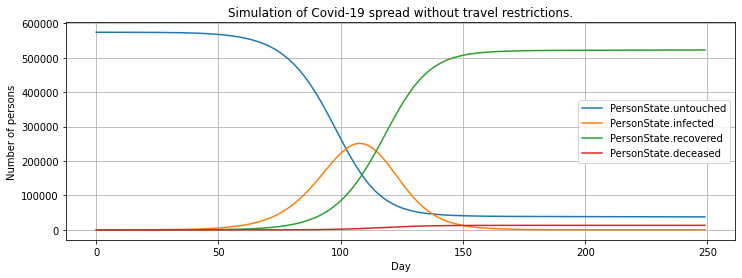

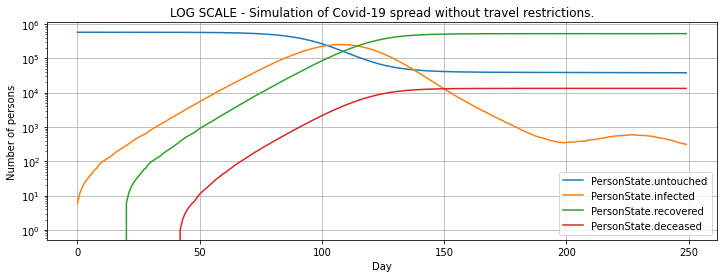

In [13]:
run(storage)


Population:        574,280
Deceased:                0 ( 0.0 %)
Peak infected:           0 ( 0.0 %)
Total affected:          0 ( 0.0 %)


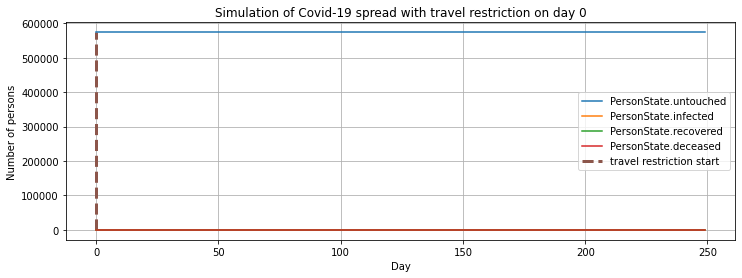

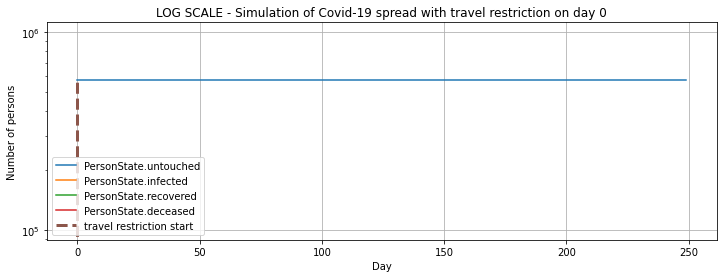

In [14]:
run(storage, travel_restriction_day=0)


Population:        574,280
Deceased:            9,747 ( 1.7 %)
Peak infected:     177,669 (30.9 %)
Total affected:    393,317 (68.5 %)


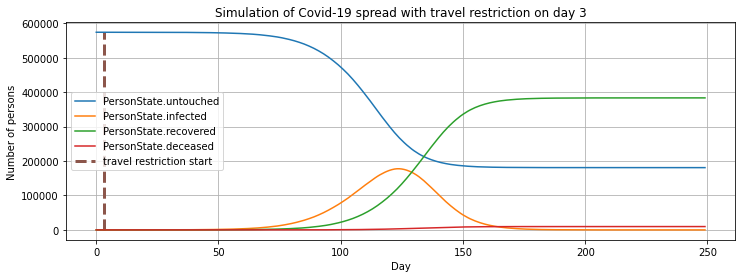

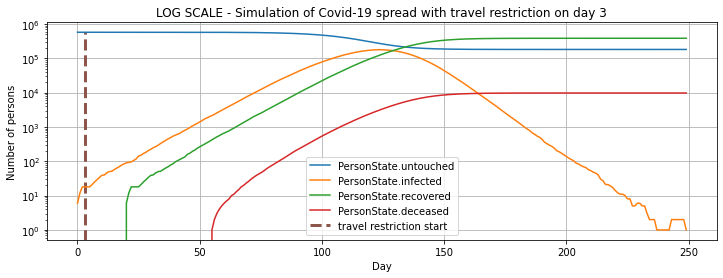

In [15]:
run(storage, travel_restriction_day=3)


Population:        574,280
Deceased:           12,159 ( 2.1 %)
Peak infected:     232,477 (40.5 %)
Total affected:    489,621 (85.3 %)


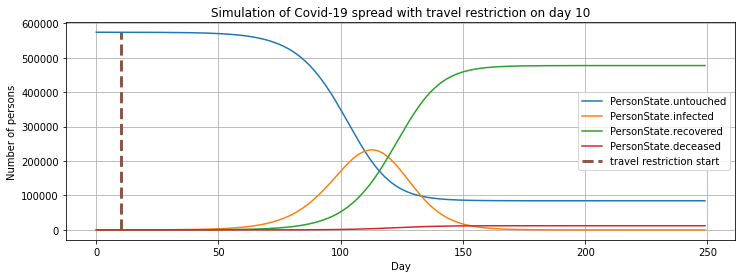

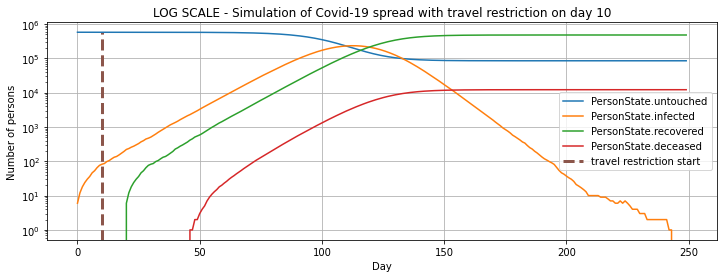

In [16]:
run(storage, travel_restriction_day=10)


Population:        574,280
Deceased:           13,285 ( 2.3 %)
Peak infected:     245,655 (42.8 %)
Total affected:    534,810 (93.1 %)


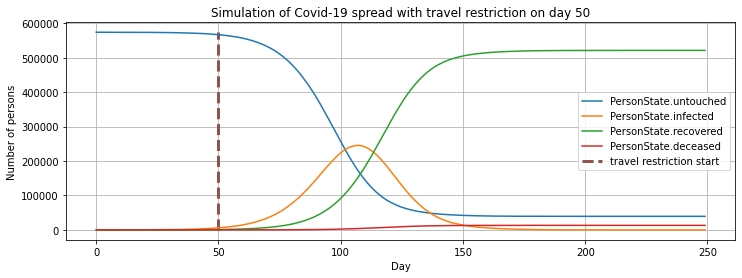

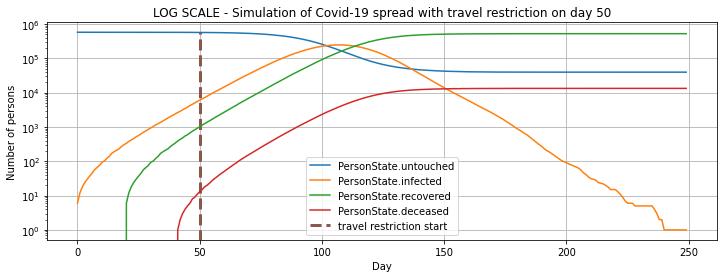

In [17]:
run(storage, travel_restriction_day=50)


Population:        574,280
Deceased:            9,866 ( 1.7 %)
Peak infected:      91,168 (15.9 %)
Total affected:    403,628 (70.3 %)


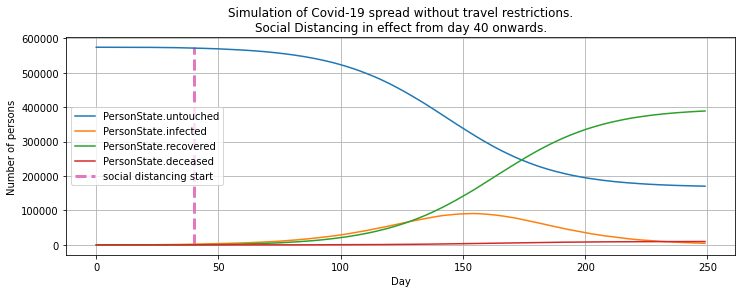

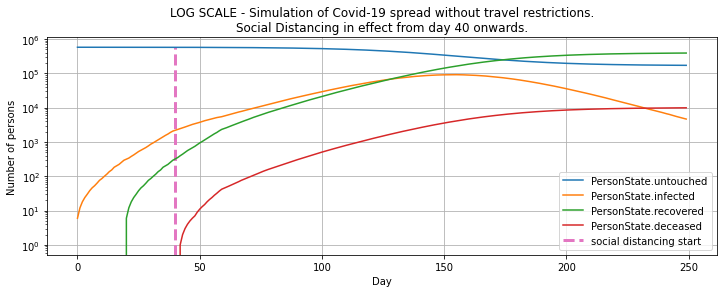

In [18]:
run(storage, social_distancing_day=40)


Population:        574,280
Deceased:            9,958 ( 1.7 %)
Peak infected:      93,389 (16.3 %)
Total affected:    404,917 (70.5 %)


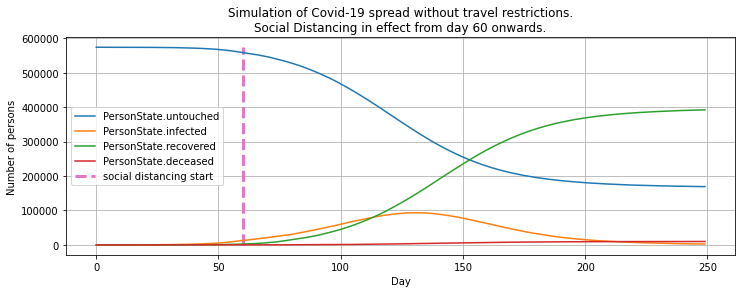

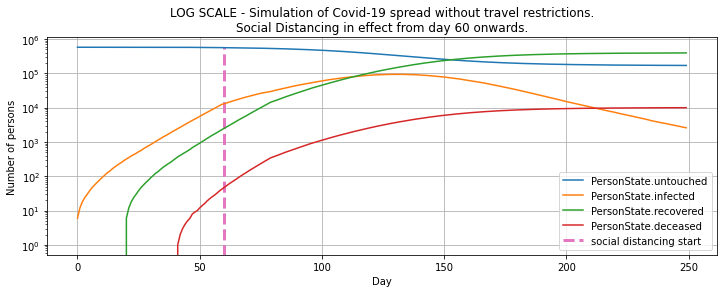

In [19]:
run(storage, social_distancing_day=60)


Population:        574,280
Deceased:           10,439 ( 1.8 %)
Peak infected:     123,581 (21.5 %)
Total affected:    423,797 (73.8 %)


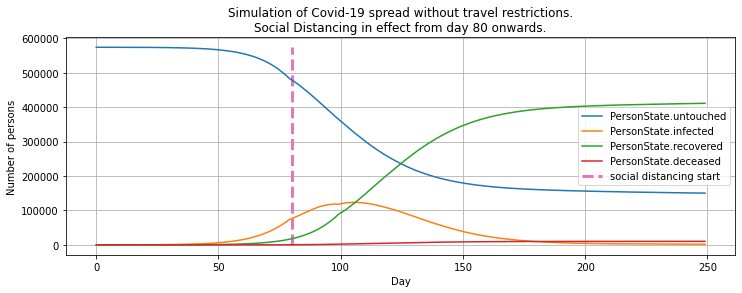

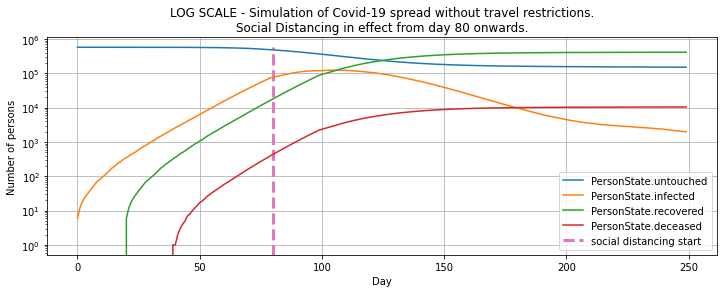

In [20]:
run(storage, social_distancing_day=80)


Population:        574,280
Deceased:            9,629 ( 1.7 %)
Peak infected:      90,188 (15.7 %)
Total affected:    393,350 (68.5 %)


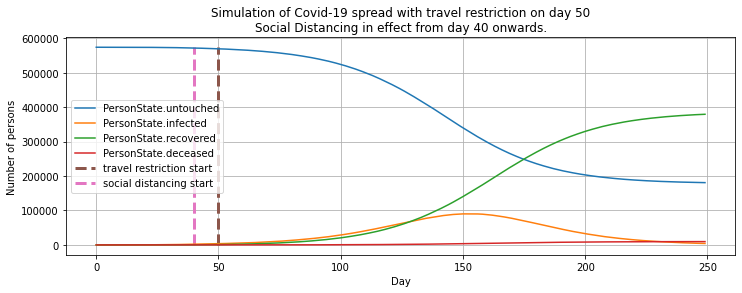

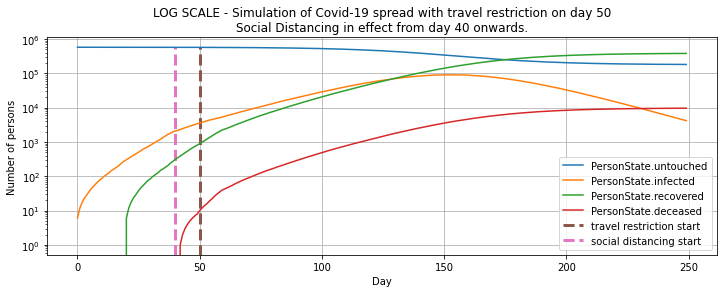

In [21]:
run(storage, social_distancing_day=40, travel_restriction_day=50)

### Comparison

In [46]:
(
    pd.DataFrame([
        {
            "tr_day": sr.travel_restriction_day,
            "sd_day": sr.social_distancing_day,
            "perc_deceased": sr.perc_deceased,
            "perc_peak_infected": sr.perc_peak_infected,
            "perc_total_affected": sr.perc_total_affected,
        } for key, sr in storage.results.items()]
    )
    .set_index(["tr_day", "sd_day"])
    .query("tr_day != 0")
    .round(2)
    .sort_values(by="perc_peak_infected", ascending=False)
)

perc_deceased  perc_peak_infected  perc_total_affected
tr_day sd_day                                                        
NaN    NaN              2.31               43.72                93.40
50.0   NaN              2.31               42.78                93.13
10.0   NaN              2.12               40.48                85.26
3.0    NaN              1.70               30.94                68.49
NaN    80.0             1.82               21.52                73.80
       60.0             1.73               16.26                70.51
       40.0             1.72               15.88                70.28
50.0   40.0             1.68               15.70                68.49

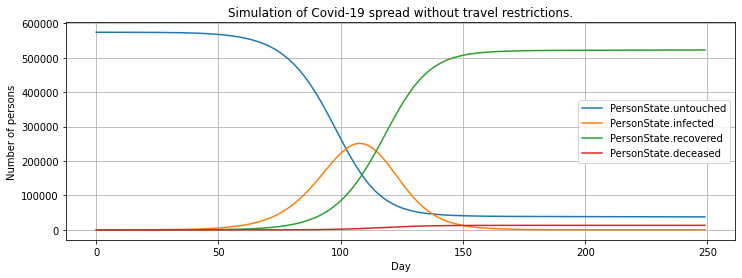

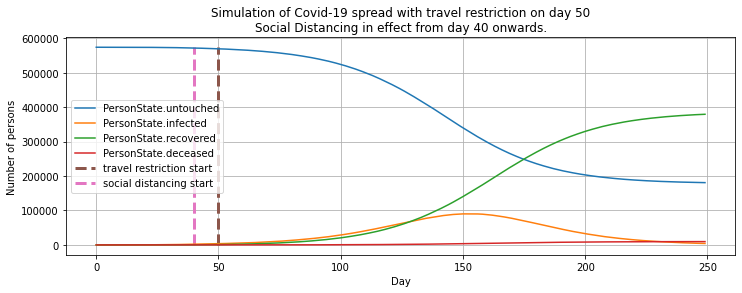

In [45]:
storage["SimulationResult(n_days=250, tr_day=None, sd_day=None)"].plot_count_curves()
storage["SimulationResult(n_days=250, tr_day=50, sd_day=40)"].plot_count_curves()